# Titanic - Machine Learning from Disaster
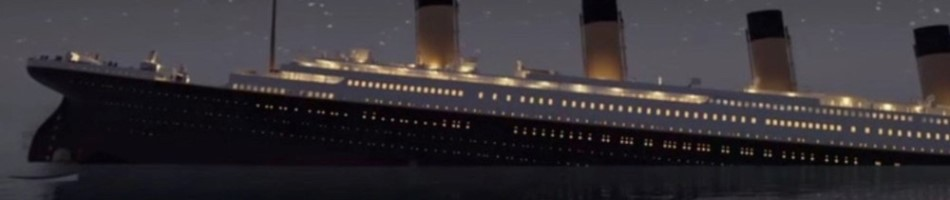
[Overview - Kaggle.com](https://www.kaggle.com/competitions/titanic/overview)

**Описание данных:** <br>
***Survival*** - выжил пассажир или нет, бинарная целевая переменная (0/1) <br>
***PassengerId*** - ID пассажира <br>
***Pclass*** - класс билета пассажира. *A proxy for socio-economic status (SES). 1st = Upper, 2nd = Middle, 3rd = Lower* <br>
***Name*** - имя пассажира <br>
***Sex*** - пол пассажира <br>
***Age*** - возраст пассажира, лет <br>
***SibSp*** - siblings / spouses - количество братьев и сестер / супругов на бору <br>
***Parch*** - parents / children - количество родителей / детей на борту <br>
***Ticket*** - номер билета пассажира <br>
***Fare*** - стоимость билета <br>
***Cabin*** - номер каюты пассажира <br>
***Embarked*** - порт отправления (где пассажир сел на борт) <br>


In [217]:
!pip install optuna

In [218]:
import optuna
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from plotly import offline as plotly_offline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

In [219]:
# const definition
RANDOM_SEED = 42

**Загружаем данные**

In [220]:
url_train = 'https://drive.google.com/file/d/1nHQC99k2GlUl06yshOX76DUKTelVVJbe/view?usp=drive_link'
url_train = 'https://drive.google.com/uc?id=' + url_train.split('/')[-2]
train_data = pd.read_csv(url_train)

In [221]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [222]:
submission_url = 'https://drive.google.com/file/d/1x__b9TA3x_sqJrZb_bcvqQfAUa3ZqCXx/view?usp=drive_link'
submission_url = 'https://drive.google.com/uc?id=' + submission_url.split('/')[-2]
sub_data = pd.read_csv(submission_url)

In [223]:
sub_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [224]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [225]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Для начала используем только интуитивно понятные признаки:** <br>
*Pclass*,   *Sex*,   *Age*,   *SibSp*,   *Parch*,   *Fare*,   *Embarked*

In [226]:
X = train_data.iloc[:, 2:].copy()
X = X.drop(['Name', 'Ticket', 'Cabin'], axis = 1)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [227]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


**Заполняем пропуски в данных - Age, Embarked**

In [228]:
# fill age with median and embarked with mode values
X['AgeImputed'] = X['Age'].fillna(X['Age'].median())
X['EmbarkedImputed'] = X['Embarked'].fillna(X['Embarked'].mode()[0])
X = X.drop(['Embarked', 'Age'], axis = 1)
X.isnull().sum()

,0
Pclass,0
Sex,0
SibSp,0
Parch,0
Fare,0
AgeImputed,0
EmbarkedImputed,0


In [229]:
# check data type
X.dtypes

,0
Pclass,int64
Sex,object
SibSp,int64
Parch,int64
Fare,float64
AgeImputed,float64
EmbarkedImputed,object


In [230]:
Y = train_data['Survived']
Y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


**Кодируем категориальные признаки: **


1.   Age с помощью Ordinal Encoder из Sklearn
2.   Embarked с помощью one-hot encoding, метод из библиотеки pandas



In [231]:
# encode cat features
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
X['Sex'] = encoder.fit_transform(X['Sex'].values.reshape(-1, 1))
X = pd.get_dummies(X, columns = ['EmbarkedImputed'])
X.head()

,Pclass,Sex,SibSp,Parch,Fare,AgeImputed,EmbarkedImputed_C,EmbarkedImputed_Q,EmbarkedImputed_S
0,3,1.0,1,0,7.2500,22.0,False,False,True
1,1,0.0,1,0,71.2833,38.0,True,False,False
2,3,0.0,0,0,7.9250,26.0,False,False,True
3,1,0.0,1,0,53.1000,35.0,False,False,True
4,3,1.0,0,0,8.0500,35.0,False,False,True


**Разделение данных на обучающую и валидационную выборки**

In [232]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, shuffle = True, train_size = 0.8,
                                                      random_state = RANDOM_SEED, stratify = Y)

In [233]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

**Обучение модели и оценка ее качества** <br>
Построим baseline решение на основе линейной модели классификации и попробуем его улучшить, обучив модель Random Forest

In [234]:
# Logistic Regression model
model_LR = LogisticRegression()
model_LR.fit(X_train_scaled, Y_train)
Y_train_LR = model_LR.predict(X_train_scaled)
train_score_LR = metrics.accuracy_score(Y_train_LR, Y_train)
print('Logistic regression train accuracy is', np.round(train_score_LR,4))
Y_pred_LR = model_LR.predict(X_valid_scaled)
valid_score_LR = metrics.accuracy_score(Y_pred_LR, Y_valid)
print('Logistic regression valid accuracy is', np.round(valid_score_LR,4))

Logistic regression train accuracy is 0.8076
Logistic regression valid accuracy is 0.8045


In [235]:
# Random Forest model
model_RFC = RandomForestClassifier(random_state = RANDOM_SEED)
model_RFC.fit(X_train_scaled, Y_train)
Y_train_RFC = model_RFC.predict(X_train_scaled)
train_score_RFC = metrics.accuracy_score(Y_train_RFC, Y_train)
print('Random Forest train accuracy is', np.round(train_score_RFC,4))

Y_pred_RFC = model_RFC.predict(X_valid_scaled)
valid_score_RFC = metrics.accuracy_score(Y_pred_RFC, Y_valid)
print('Random Forest valid accuracy is', np.round(valid_score_RFC,4))


Random Forest train accuracy is 0.9817
Random Forest valid accuracy is 0.8156


**Попробуем извлечь полезную информацию из признака Name** <br>
Распарсим значения и попробуем определить профессию и социальный статус пассажира

In [236]:
# parse "name" feature
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
print(train_data[['Name', 'Title']].head(10))
print(train_data['Title'].value_counts())

                                                Name   Title
0                            Braund, Mr. Owen Harris      Mr
1  Cumings, Mrs. John Bradley (Florence Briggs Th...     Mrs
2                             Heikkinen, Miss. Laina    Miss
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)     Mrs
4                           Allen, Mr. William Henry      Mr
5                                   Moran, Mr. James      Mr
6                            McCarthy, Mr. Timothy J      Mr
7                     Palsson, Master. Gosta Leonard  Master
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)     Mrs
9                Nasser, Mrs. Nicholas (Adele Achem)     Mrs
Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64


In [237]:
title_mapping = {
    'Mr': 'NoTitle',
    'Miss': 'NoTitle',
    'Mlle': 'NoTitle',
    'Ms': 'NoTitle',
    'Mrs': 'NoTitle',
    'Mme': 'NoTitle',
    'Master': 'Master',
    'Capt': 'Military',
    'Col': 'Military',
    'Major': 'Military',
    'Dr': 'Doctor',
    'Rev': 'Reverend',
    'Lady': 'Noble',
    'Countess': 'Noble',
    'Sir': 'Noble',
    'Don': 'Noble',
    'Dona': 'Noble',
    'Jonkheer': 'Noble'
}

train_data['Title'] = train_data['Title'].replace(title_mapping)
print(train_data[['Name', 'Title']])
print(train_data['Title'].value_counts())

                                                  Name     Title
0                              Braund, Mr. Owen Harris   NoTitle
1    Cumings, Mrs. John Bradley (Florence Briggs Th...   NoTitle
2                               Heikkinen, Miss. Laina   NoTitle
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)   NoTitle
4                             Allen, Mr. William Henry   NoTitle
..                                                 ...       ...
886                              Montvila, Rev. Juozas  Reverend
887                       Graham, Miss. Margaret Edith   NoTitle
888           Johnston, Miss. Catherine Helen "Carrie"   NoTitle
889                              Behr, Mr. Karl Howell   NoTitle
890                                Dooley, Mr. Patrick   NoTitle

[891 rows x 2 columns]
Title
NoTitle     828
Master       40
Doctor        7
Reverend      6
Noble         5
Military      5
Name: count, dtype: int64


In [238]:
X_add = X.copy()
X_add['Title'] = train_data['Title']
X_add.head(10)

,Pclass,Sex,SibSp,Parch,Fare,AgeImputed,EmbarkedImputed_C,EmbarkedImputed_Q,EmbarkedImputed_S,Title
0,3,1.0,1,0,7.2500,22.0,False,False,True,NoTitle
1,1,0.0,1,0,71.2833,38.0,True,False,False,NoTitle
2,3,0.0,0,0,7.9250,26.0,False,False,True,NoTitle
3,1,0.0,1,0,53.1000,35.0,False,False,True,NoTitle
4,3,1.0,0,0,8.0500,35.0,False,False,True,NoTitle
5,3,1.0,0,0,8.4583,28.0,False,True,False,NoTitle
6,1,1.0,0,0,51.8625,54.0,False,False,True,NoTitle
7,3,1.0,3,1,21.0750,2.0,False,False,True,Master
8,3,0.0,0,2,11.1333,27.0,False,False,True,NoTitle
9,2,0.0,1,0,30.0708,14.0,True,False,False,NoTitle


In [239]:
X_add = pd.get_dummies(X_add, columns = ['Title'], drop_first = True)
X_add.head()

,Pclass,Sex,SibSp,Parch,Fare,AgeImputed,EmbarkedImputed_C,EmbarkedImputed_Q,EmbarkedImputed_S,Title_Master,Title_Military,Title_NoTitle,Title_Noble,Title_Reverend
0,3,1.0,1,0,7.2500,22.0,False,False,True,False,False,True,False,False
1,1,0.0,1,0,71.2833,38.0,True,False,False,False,False,True,False,False
2,3,0.0,0,0,7.9250,26.0,False,False,True,False,False,True,False,False
3,1,0.0,1,0,53.1000,35.0,False,False,True,False,False,True,False,False
4,3,1.0,0,0,8.0500,35.0,False,False,True,False,False,True,False,False


In [240]:
X_train_add, X_valid_add, Y_train_add, Y_valid_add = train_test_split(X_add, Y, shuffle = True, train_size = 0.8,
                                                      random_state = RANDOM_SEED, stratify = Y)

In [241]:
scaler = StandardScaler()
X_train_scaled_add = scaler.fit_transform(X_train_add)
X_valid_scaled_add = scaler.transform(X_valid_add)

In [242]:
# Random Forest model
model_RFC_add = RandomForestClassifier(random_state = RANDOM_SEED)
model_RFC_add.fit(X_train_scaled_add, Y_train_add)
Y_train_RFC_add = model_RFC_add.predict(X_train_scaled_add)
train_score_RFC_add = metrics.accuracy_score(Y_train_RFC_add, Y_train_add)
print('Random Forest train accuracy is', np.round(train_score_RFC_add,4))

Y_pred_RFC_add = model_RFC_add.predict(X_valid_scaled_add)
valid_score_RFC_add = metrics.accuracy_score(Y_pred_RFC_add, Y_valid_add)
print('Random Forest valid accuracy is', np.round(valid_score_RFC_add,4))

Random Forest train accuracy is 0.9831
Random Forest valid accuracy is 0.838


**Оптимизируем модель - подберем гиперпараметры в процессе кросс-валидации** <br>
Используем библиотеку Optuna для оптимизации гиперпараметров

In [243]:
tuneRF = True
if tuneRF:
    # hp tunning for random forest
    def objective(trial):
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            #'max_depth': trial.suggest_int('max_depth', 1, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
            'max_samples': trial.suggest_float('max_samples', 0.1, 1.0),
            'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-8, 1.0, log = True),
            'random_state': trial.suggest_int('random_state', 42, 42)
            }

        model = RandomForestClassifier(**param)
        skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_SEED)
        scores = cross_val_score(model, X_add, Y, cv = skf, scoring = 'accuracy')
        return scores.mean()

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    sampler = optuna.samplers.TPESampler(seed = 42)
    studyRF = optuna.create_study(sampler = sampler, direction = 'maximize')
    studyRF.optimize(objective, n_trials = 100, show_progress_bar = True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [244]:
# print best params
print(studyRF.best_value)
print(studyRF.best_params)

0.8506998932898122
{'n_estimators': 253, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.5515797912357997, 'max_samples': 0.6603457842744153, 'ccp_alpha': 4.564409555809751e-06, 'random_state': 42}


**Визуализация процесса оптимизации модели**

In [245]:
fig = optuna.visualization.plot_optimization_history(studyRF)
plotly_offline.iplot(fig)

In [246]:
model_RF_optim = RandomForestClassifier()
model_RF_optim.set_params(**studyRF.best_params)
model_RF_optim.fit(X_train_scaled_add, Y_train_add)

RandomForestClassifier(ccp_alpha=4.564409555809751e-06,
                       max_features=0.5515797912357997,
                       max_samples=0.6603457842744153, min_samples_leaf=3,
                       min_samples_split=5, n_estimators=253, random_state=42)

In [247]:
Y_pred_RFC_add_optim = model_RF_optim.predict(X_valid_scaled_add)
valid_score_RFC_add_optim = metrics.accuracy_score(Y_pred_RFC_add_optim, Y_valid)
print('Random Forest optimized valid accuracy is', np.round(valid_score_RFC_add_optim,4))

Random Forest optimized valid accuracy is 0.8101


**Выведем качество обученных моделей на валидационной выборке**

In [248]:
print('Logistic Regression accuracy is', np.round(valid_score_LR,4))
print('Random Forest accuracy is', np.round(valid_score_RFC,4))
print('Random Forest with "Name feature" accuracy is', np.round(valid_score_RFC_add,4))
print('Random Forest with "Name feature" and optimization accuracy is', np.round(valid_score_RFC_add_optim,4))

Logistic Regression accuracy is 0.8045
Random Forest accuracy is 0.8156
Random Forest with "Name feature" accuracy is 0.838
Random Forest with "Name feature" and optimization accuracy is 0.8101


**Оценка важности признаков моделью**

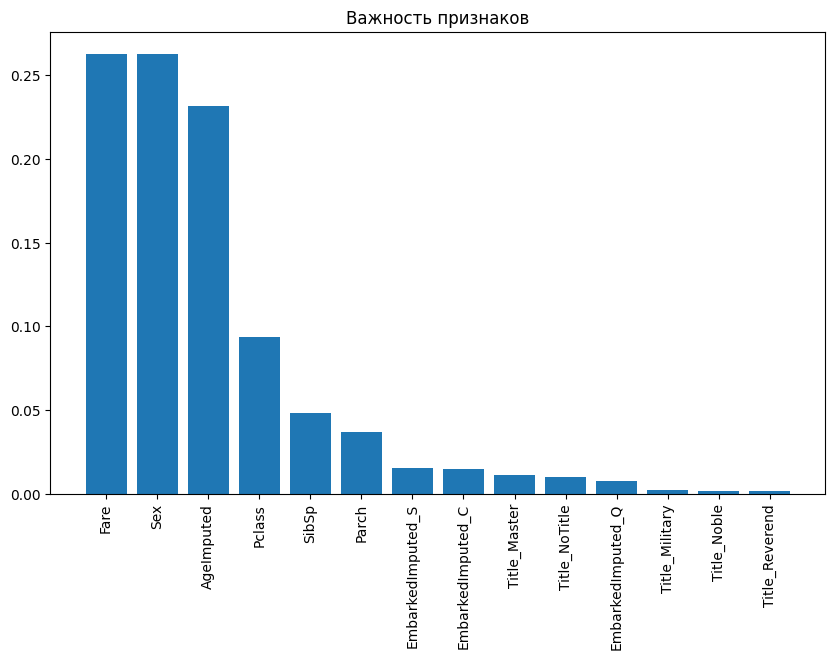

In [249]:
best_model = model_RFC_add
importances = best_model.feature_importances_
feature_names = X_train_add.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Важность признаков")
plt.bar(range(X_train_add.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_add.shape[1]), feature_names[indices], rotation=90)
plt.show()